# Exploratory Data Analysis

Import required packages

In [151]:
def import_package():
    #---------------------------------------------------------
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.model_selection import train_test_split
    
    #-----------------------------------------------------
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.linear_model import LinearRegression, Ridge, Lasso
    from sklearn.svm import SVR
    
    #--------------------------------------------------------
    from sklearn.model_selection import cross_val_score, GridSearchCV
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.metrics import mean_absolute_error
    
    #---------------------------------------------------------
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
    import warnings
    from sklearn.exceptions import ConvergenceWarning
    
    #---------------------------------------------------------
    import io
    import nbformat
    from pathlib import Path
    from nbconvert.preprocessors import Preprocessor
    from nbconvert import HTMLExporter
    
import_package()

Load data

In [152]:
def read_dataset(file_path):
    data = pd.read_excel(file_path)
    return data  

In [153]:
file_path = r'D:\Desktop\MS-ML-Internship\4.Multi Channel Analytics\Account_Level_Analysis.xlsx'
data = read_dataset(file_path)

### 数据处理
1.分解和扩展了 x 和 Account_Corrected列<br>
2.重命名了这些扩展列以及其他几个指定的列<br>
3.对Acount列进行了独热编码<br>
4.删除了原始的x,Account_Corrected,Note,Acquisitiontime,Account列 <br>

In [114]:
def process_data(data):
    """
    Processes the data by expanding, renaming, and encoding certain columns.

    Parameters:
    data (DataFrame): The original pandas DataFrame to be processed.

    Returns:
    DataFrame: A processed DataFrame with expanded, renamed, and encoded columns.
    """
    
    # Splitting and expanding the 'x' column
    x_expanded = data['x'].str.split(',', expand=True)
    # Renaming the columns for clarity
    x_expanded.columns = [f'X{i}' for i in range(x_expanded.shape[1])]
    
    # Splitting and expanding the 'Account_Corrected' column
    account_corrected_expanded = data['Account_Corrected'].str.split(',', expand=True)
    # Renaming the columns for clarity
    account_corrected_expanded.columns = [f'Corrected_X{i}' for i in range(account_corrected_expanded.shape[1])]
    
    # Joining these expanded columns back to the original dataframe
    df_expanded = data.join(x_expanded).join(account_corrected_expanded)
    
    # Convert all new columns to numeric type
    for col in x_expanded.columns:
        df_expanded[col] = pd.to_numeric(df_expanded[col], errors='coerce')
    
    for col in account_corrected_expanded.columns:
        df_expanded[col] = pd.to_numeric(df_expanded[col], errors='coerce')
    
    # Renaming the columns
    df_expanded.rename(columns={'KOL_Estimated': 'KOL', 
                                'Transfer_Estimated': 'Transfer', 
                                'Account_Category': 'Account'}, inplace=True)
    
    #One-Hot encoding for account category
    acount_dummies = pd.get_dummies(df_expanded['Account'], prefix='Account')
    
    # Joining the new dummy columns to the original dataframe
    df = df_expanded.join(acount_dummies)
    
    # Dropping the original 'x' and 'Account_Corrected' columns
    df = df.drop(['x', 'Account_Corrected','Note','Acquisition time','Account','KOL'], axis=1)
    
    # Display the first few rows of the expanded dataframe
    #df.head()
    return df  

In [115]:
df = process_data(data)

## 相关系数处理
1.绘制相关系数热力图

2.生成相关系数列表

3.筛选提取特征

In [116]:
def Cor_process(df):
    """
    生成相关系数热力图
    生成相关系数列表
    预设置阈值 correlation_threshold = 0.2
    返回选择的特征filtered_features对应dataframe
    """
    # Calculating the correlation matrix for the processed dataframe
    corr_matrix = df.corr()
    
    # Extracting the correlation values with 'Transfer' and sorting them
    corr_with_transfer = corr_matrix['Transfer'].drop('Transfer')  # Dropping the correlation of 'Transfer' with itself
    sorted_corr_with_transfer = corr_with_transfer.sort_values(ascending=False)
    
    # Print the sorted correlation list
    #print(sorted_corr_with_transfer)
    
    # Extracting correlations with 'Transfer' and filtering based on the threshold
    correlation_threshold = 0.2
    high_corr_with_transfer = corr_matrix['Transfer'].abs().sort_values(ascending=False)
    filtered_features = high_corr_with_transfer[high_corr_with_transfer > correlation_threshold].index.tolist()

    # Ensure Account_ACC1 & Account_ACC2 are included in the list
    if 'Account_ACC1' not in filtered_features:
        filtered_features.append('Account_ACC1')
    if 'Account_ACC2' not in filtered_features:
        filtered_features.append('Account_ACC2')
    
    # Creating a smaller correlation matrix for the filtered features
    small_corr_matrix = df[filtered_features].corr()
    
    # Plotting the heatmap for the filtered features
    plt.figure(figsize=(16, 12))
    sns.heatmap(small_corr_matrix, 
                cmap='coolwarm', 
                annot=False, 
                fmt=".1f", 
                linewidths=.5, 
                cbar_kws={"shrink": .5})
    print('-------------------------------------------------'+'<Heat Map for variables>'+'-------------------------------------------------')
    plt.title('Correlation Matrix Heatmap for High Correlation with Transfer', fontsize=18)
    plt.show()

    return df[filtered_features]


### 绘制散点图&箱线图
查看账户类型的特征与转换率的线性关系

查看数据分布特征，检测异常值

In [118]:
def scatter_plot_for_category(processed_df):
    # Extracting the Account one-hot encoded columns
    account_columns = [col for col in processed_df.columns if col.startswith('Account_')]
    
    # Filtering the columns for plotting (excluding the 'Transfer' column and Account one-hot encoded columns)
    plotting_columns = [col for col in processed_df.columns if col not in account_columns and col != 'Transfer']
    
    # Adjusting the number of rows and columns for the subplots
    num_rows = 7  # Adjusting the number of rows in the subplot grid
    num_cols = 6  # Adjusting the number of columns in the subplot grid
    print('-------------------------------------------------'+'<Scatter Plots>'+'-------------------------------------------------')
    # Plotting scatter plots for each Account type
    for account_col in account_columns:
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 20))
        fig.subplots_adjust(hspace=0.6, wspace=0.6)
        fig.suptitle(f'Scatter Plots for {account_col}', fontsize=18)
    
        for i, col in enumerate(plotting_columns):
            if i >= num_rows * num_cols:
                break  # Limit the number of plots for readability
            ax = axes[i // num_cols, i % num_cols]
            # Filter data for the specific Account type
            filtered_df = processed_df[processed_df[account_col] == 1]
            sns.scatterplot(x=filtered_df[col], y=filtered_df['Transfer'], ax=ax)
            ax.set_title(f'{col}')
            ax.set_xlabel(col)
            ax.set_ylabel('Transfer')
        
        # Hide empty subplots if any
        for j in range(i + 1, num_rows * num_cols):
            fig.delaxes(axes[j // num_cols, j % num_cols])
        
        plt.show()

In [120]:
def box_plot(filtered_df):
    # Set up the layout for subplots
    num_features = len(filtered_df.columns)  # Total number of features
    num_cols = 4  # Define the number of columns (subplots per row)
    num_rows = num_features // num_cols + (num_features % num_cols > 0)  # Calculate the number of rows needed
    
    # Create a large canvas to fit all subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between subplots
    
    # Plot the box plot for each feature
    for i, feature in enumerate(filtered_df.columns):
        ax = axes[i // num_cols, i % num_cols]  # Locate the position of the subplot
        sns.boxplot(y=filtered_df[feature], ax=ax)  # Draw box plot
        ax.set_title(f'Box Plot of {feature}')  # Set title of the subplot
        ax.set_ylabel(feature)  # Set label of the y-axis
    
    # Hide any remaining subplots if the last row is not full
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes[j // num_cols, j % num_cols])
    
    plt.show()  # Display the plot

# Model Fitting

In [122]:
def train_dataset_split(processed_df):
    # 定义特征和标签
    X = processed_df.drop('Transfer', axis=1)  # 特征是除了'Transfer'的所有列
    y = processed_df['Transfer']  # 标签是'Transfer'
    
    # 分割数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # 输出分割结果
    print('-----------------------------')
    print("Training set size:", X_train.shape[0])
    print('-----------------------------')
    print("Test set size:", X_test.shape[0])

    return X, y, X_train, X_test, y_train, y_test

### Regression Part 1

In [124]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [132]:
def train_and_evaluate_models_p1(X_train, X_test, y_train, y_test):
    
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    # 定义模型
    models = {
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Ridge': Ridge(random_state=42),
        'Lasso': Lasso(random_state=42),
        'SVM': SVR(),
        'Linear': LinearRegression()
    }

    # 参数网格
    param_grids = {
        'Decision Tree': {'max_depth': [None, 1, 2, 3, 5, 10, 20, 30], 'min_samples_split': [2, 3, 4, 5]},
        'Ridge': {'alpha': [ 0.1, 0.5, 1, 2, 5, 10]},
        'Lasso': {'alpha': [ 0.1, 0.5, 1, 2, 5, 10]},
        'SVM': {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.5]}
    }

    scores = {}
    
    # 绘制子图
    num_models = len(models)
    num_cols = 3
    num_rows = -(-num_models // num_cols)  

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 8))
    axes = axes.flatten()

    # 模型评估指标字典
    evaluation_scores = {
        'MSE': [],
        'R2': [],
        'MAE': [],
        'MAPE': []
    }

    #模型训练
    for i, (name, model) in enumerate(models.items()):
        
        # 初始化模型的得分
        scores[name] = {}
        
        # 网格搜索，除了线性回归
        if name != 'Linear':
            grid_search = GridSearchCV(model, param_grids[name], cv=4, scoring='neg_mean_squared_error')
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_
            scores[name] = {'Best Parameters': grid_search.best_params_}
        else:
            model.fit(X_train, y_train)
        

        # 预测和评分
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mape_score = mape(y_test, y_pred)

        # 存储分数
        scores[name] = {
            'MSE': mse,
            'R2': r2,
            'MAE': mae,
            'MAPE': mape_score,
            'Model': model
        }

        # 收集评估分数用于后续可视化
        evaluation_scores['MSE'].append(mse)
        evaluation_scores['R2'].append(r2)
        evaluation_scores['MAE'].append(mae)
        evaluation_scores['MAPE'].append(mape_score)

        # 可视化预测结果
        axes[i].scatter(y_test, y_pred, alpha=0.7, color='red')
        axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='green')
        axes[i].set_title(f'{name} Regression')
        axes[i].set_xlabel('Actual Transfer')
        axes[i].set_ylabel('Predicted Transfer')

    # 删除多余的子图
    for j in range(num_models, num_rows * num_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # 分数可视化
    metrics = list(evaluation_scores.keys())
    fig, axs = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 4))
    
    for i, metric in enumerate(metrics):
        axs[i].bar(range(len(models)), evaluation_scores[metric], tick_label=list(models.keys()))
        axs[i].set_title(f'{metric} Comparison')
        axs[i].set_xticklabels(list(models.keys()), rotation=45, ha='right')
        axs[i].set_ylabel(metric)

    plt.tight_layout()
    plt.show()

    return scores

### Regression Part 2

In [134]:
def train_and_evaluate_models_p2(X_train, X_test, y_train, y_test):
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    # 定义模型
    models = {
        'KNN': KNeighborsRegressor(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'AdaBoost': AdaBoostRegressor(random_state=42),
        'GBRT': GradientBoostingRegressor(random_state=42),
        'Bagging': BaggingRegressor(random_state=42),
        'Extra Trees': ExtraTreesRegressor(random_state=42)
    }

    # 参数网格
    param_grids = {
        'KNN': {'n_neighbors': [1, 2, 3, 5, 7]},
        'Random Forest': {'n_estimators': [10, 20, 50,100], 'max_features': ['auto', 'sqrt', 'log2']},
        'AdaBoost': {'n_estimators': [10, 20, 50, 100, 200], 'learning_rate': [0.01, 0.1, 1]},
        'GBRT': {'n_estimators': [10, 20, 50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5]},
        'Bagging': {'n_estimators': [10, 50, 100]},
        'Extra Trees': {'n_estimators': [50, 100, 200], 'max_features': ['auto', 'sqrt', 'log2']}
    }

    scores = {}
    
    # Initialize the number of models, rows, and columns for the subplot arrangement
    num_models = len(models)
    num_cols = 3
    num_rows = -(-num_models // num_cols)  # Ceiling division to determine number of rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 8))
    axes = axes.flatten()


    # 模型评估指标字典
    evaluation_scores = {
        'MSE': [],
        'R2': [],
        'MAE': [],
        'MAPE': []
    }
    
    #模型训练
    for i, (name, model) in enumerate(models.items()):
        
        # 初始化模型的得分
        scores[name] = {}
        
        # 网格搜索，除了线性回归
        if name != 'Linear':
            grid_search = GridSearchCV(model, param_grids[name], cv=4, scoring='neg_mean_squared_error')
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_
            scores[name] = {'Best Parameters': grid_search.best_params_}
        else:
            model.fit(X_train, y_train)

        # 预测和评分
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mape_score = mape(y_test, y_pred)

        # 存储分数
        scores[name] = {
            'MSE': mse,
            'R2': r2,
            'MAE': mae,
            'MAPE': mape_score,
            'Model': model
        }

        # 收集评估分数用于后续可视化
        evaluation_scores['MSE'].append(mse)
        evaluation_scores['R2'].append(r2)
        evaluation_scores['MAE'].append(mae)
        evaluation_scores['MAPE'].append(mape_score)

        # 可视化预测结果
        axes[i].scatter(y_test, y_pred, alpha=0.7, color='red')
        axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='green')
        axes[i].set_title(f'{name} Regression')
        axes[i].set_xlabel('Actual Transfer')
        axes[i].set_ylabel('Predicted Transfer')

    # 删除多余的子图
    for j in range(num_models, num_rows * num_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # 分数可视化
    metrics = list(evaluation_scores.keys())
    fig, axs = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 4))
    
    for i, metric in enumerate(metrics):
        axs[i].bar(range(len(models)), evaluation_scores[metric], tick_label=list(models.keys()))
        axs[i].set_title(f'{metric} Comparison')
        axs[i].set_xticklabels(list(models.keys()), rotation=45, ha='right')
        axs[i].set_ylabel(metric)

    plt.tight_layout()
    plt.show()

    return scores

# Final Model

In [149]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):

    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    # 定义模型
    models = {
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Ridge': Ridge(random_state=42),
        'Lasso': Lasso(random_state=42),
        'SVM': SVR(),
        'Linear': LinearRegression(),
        'KNN': KNeighborsRegressor(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'AdaBoost': AdaBoostRegressor(random_state=42),
        'GBRT': GradientBoostingRegressor(random_state=42),
        'Bagging': BaggingRegressor(random_state=42),
        'Extra Trees': ExtraTreesRegressor(random_state=42)
    }

    # 参数网格
    param_grids = {
        'Decision Tree': {'max_depth': [None, 1, 2, 3, 5, 10, 20, 30], 'min_samples_split': [2, 3, 4, 5]},
        'Ridge': {'alpha': [ 0.1, 0.5, 1, 2, 5, 10]},
        'Lasso': {'alpha': [ 0.1, 0.5, 1, 2, 5, 10]},
        'SVM': {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.5]},
        'KNN': {'n_neighbors': [3, 5, 7, 9]},
        'Random Forest': {'n_estimators': [10, 50, 100], 'max_features': ['auto', 'sqrt', 'log2']},
        'AdaBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]},
        'GBRT': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5]},
        'Bagging': {'n_estimators': [10, 50, 100]},
        'Extra Trees': {'n_estimators': [50, 100, 200], 'max_features': ['auto', 'sqrt', 'log2']}
    }

    scores = {}
    evaluation_scores = {
        'MSE': [],
        'R2': [],
        'MAE': [],
        'MAPE': []
    }
    
    # 创建子图布局
    num_models = len(models)
    num_cols = 3
    num_rows = (num_models + num_cols - 1) // num_cols  # 计算子图所需行数
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
    axes = axes.flatten()  # 扁平化子图数组以便于索引

    # 模型训练和评估
    for i, (name, model) in enumerate(models.items()):
        # 网格搜索，除了线性和KNN回归（不需要超参数调整）
        if name not in ['Linear', 'KNN']:
            grid_search = GridSearchCV(model, param_grids[name], cv=4, scoring='neg_mean_squared_error')
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_
            scores[name] = {'Best Parameters': grid_search.best_params_}
        else:
            model.fit(X_train, y_train)

        # 预测和评分
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mape_score = mape(y_test, y_pred)

        # 存储分数
        scores[name] = {
            'MSE': mse,
            'R2': r2,
            'MAE': mae,
            'MAPE': mape_score,
            'Model': model
        }

        # 收集评估分数用于后续可视化
        evaluation_scores['MSE'].append(mse)
        evaluation_scores['R2'].append(r2)
        evaluation_scores['MAE'].append(mae)
        evaluation_scores['MAPE'].append(mape_score)

        # 可视化预测结果
        axes[i].scatter(y_test, y_pred, alpha=0.7, color='blue')
        axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
        axes[i].set_title(f'{name} Regression')
        axes[i].set_xlabel('Actual Transfer')
        axes[i].set_ylabel('Predicted Transfer')

    # 删除多余的子图
    for j in range(num_models, num_rows * num_cols):
        fig.delaxes(axes[j])
    print('-------------------------------------------------'+'<Pridiction Results>'+'-------------------------------------------------')
    plt.tight_layout()
    plt.show()
    
    # 分数可视化
    metrics = list(evaluation_scores.keys())
    fig, axs = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 4))
    
    for i, metric in enumerate(metrics):
        axs[i].bar(range(len(models)), evaluation_scores[metric], tick_label=list(models.keys()))
        axs[i].set_title(f'{metric} Comparison')
        axs[i].set_xticklabels(list(models.keys()), rotation=45, ha='right')
        axs[i].set_ylabel(metric)

    print('-------------------------------------------------'+'<Model Scores>'+'-------------------------------------------------')
    plt.tight_layout()
    plt.show()
    
    return scores

In [138]:
def output_best_algorithms(scores):

    metrics_df = pd.DataFrame(scores).T  
    metrics_df['MSE Rank'] = metrics_df['MSE'].rank()
    metrics_df['R2 Rank'] = metrics_df['R2'].rank(ascending=False)
    metrics_df['MAE Rank'] = metrics_df['MAE'].rank()
    metrics_df['MAPE Rank'] = metrics_df['MAPE'].rank()
    
    # 计算平均排名
    metrics_df['Average Rank'] = metrics_df[['MSE Rank', 'R2 Rank', 'MAE Rank', 'MAPE Rank']].mean(axis=1)
    
    # 对平均排名进行排序
    sorted_df = metrics_df.sort_values(by='Average Rank')

    print('--------------------------------------------------------------------------------------------------')
    print('The best Model IS :',sorted_df['Model'][0] )
    print('-------------------------------------------------'+'<Model Rankings by Average Rank:>'+'-------------------------------------------------')
    print(sorted_df['Average Rank'].sort_values())
    print('--------------------------------------------------------------------------------------------------')
    return sorted_df

In [148]:
def export_notebook_to_html():
    # 使用示例
    notebook_path = 'Multi Channel Analytics.ipynb'  # 您的 Notebook 文件路径
    output_path = 'output.html'  # 输出 HTML 文件路径
    
    # 加载 notebook
    with open(notebook_path, encoding='utf-8') as f:  # 明确指定 UTF-8 编码
        nb = nbformat.read(f, as_version=4)

    # 创建一个 HTML 导出器，并设置排除代码单元格和 Markdown
    html_exporter = HTMLExporter()
    html_exporter.exclude_input = True
    html_exporter.exclude_markdown = True

    # 导出 notebook
    body, _ = html_exporter.from_notebook_node(nb)

    # 写入 HTML 文件
    with open(output_path, 'w', encoding='utf-8') as f:  # 同样使用 UTF-8 编码写入
        f.write(body)

    print(f"Notebook exported as HTML to {output_path}")


export_notebook_to_html()

Notebook exported as HTML to output.html


In [154]:
def main(file_path):
    data = read_dataset(file_path)
    df = process_data(data)
    processed_df = Cor_process(df)
    scatter_plot_for_category(processed_df)
    box_plot(processed_df)
    X, y, X_train, X_test, y_train, y_test = train_dataset_split(processed_df)
    scores = train_and_evaluate_models(X_train, X_test, y_train, y_test)
    output = output_best_algorithms(scores)
    export_notebook_to_html()

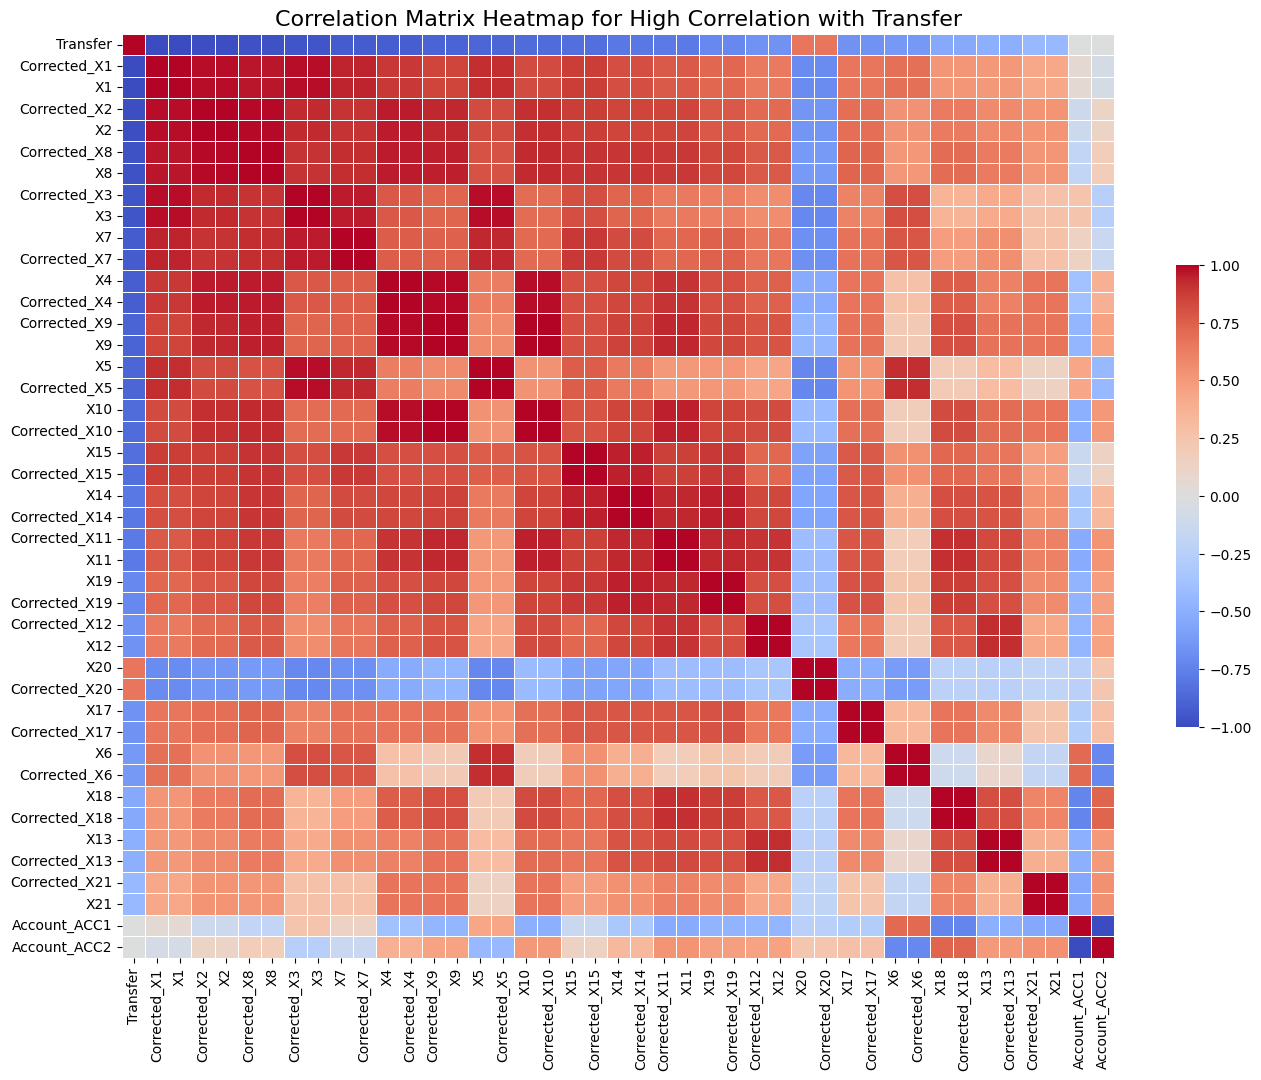

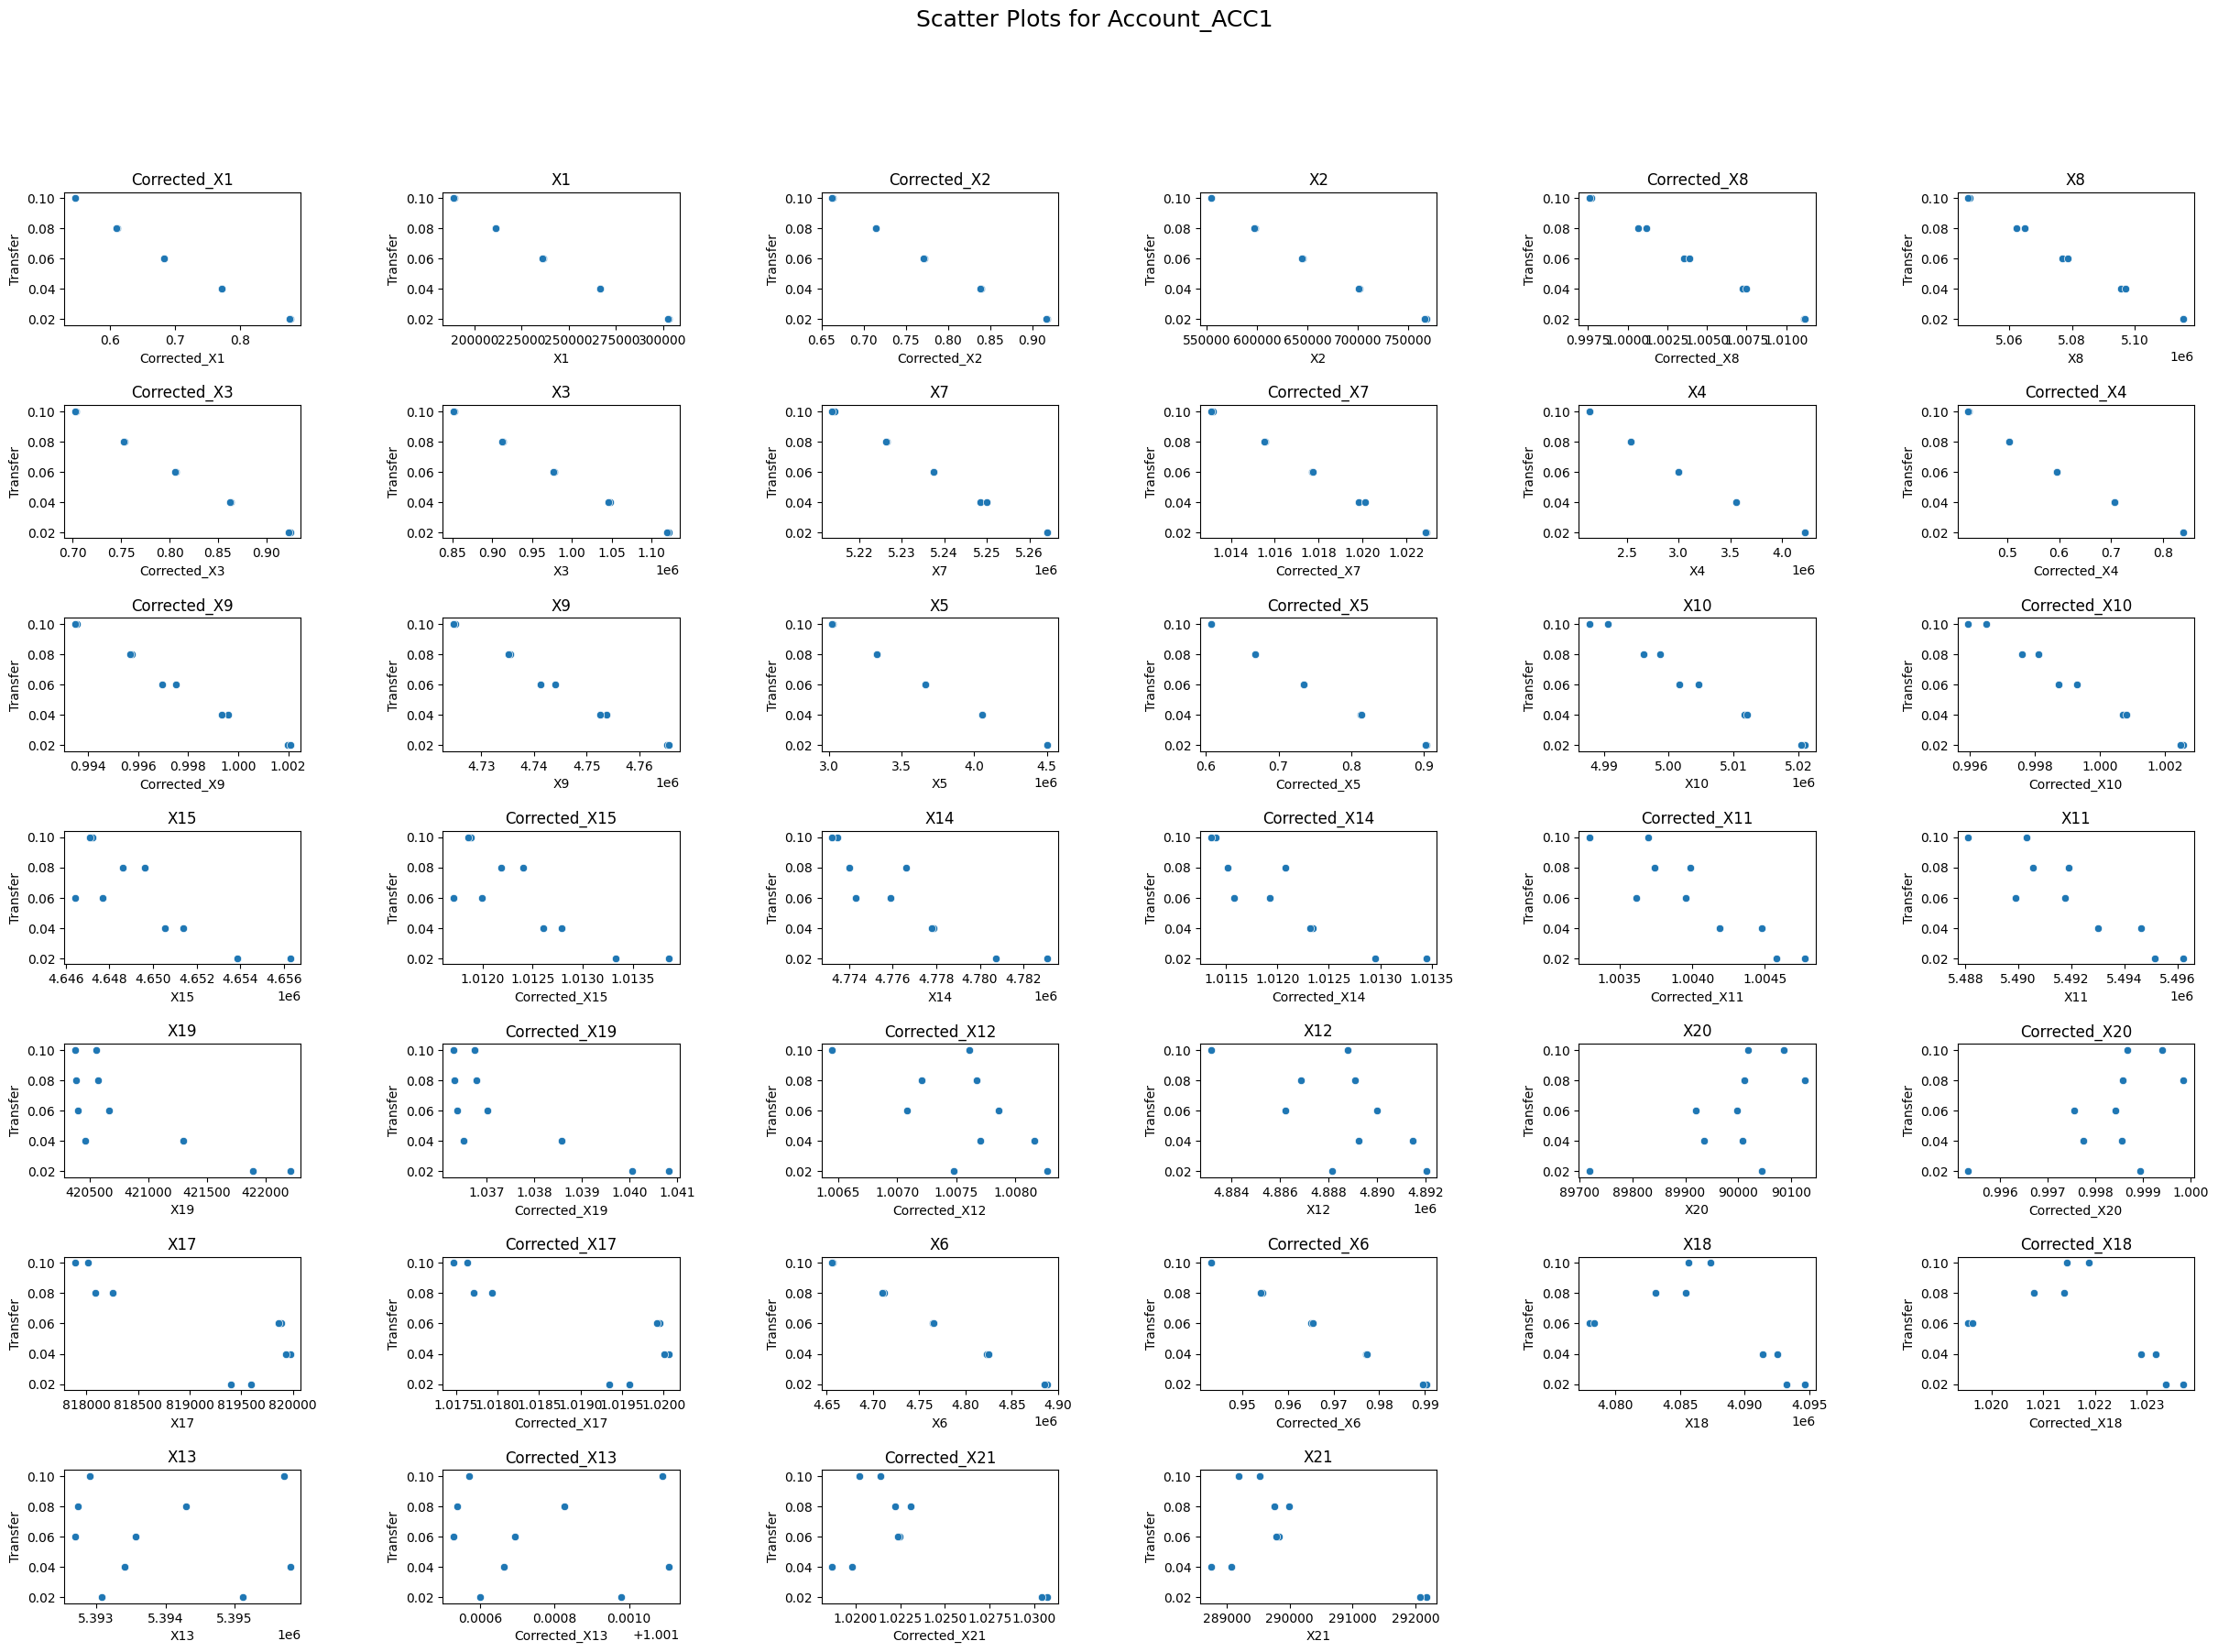

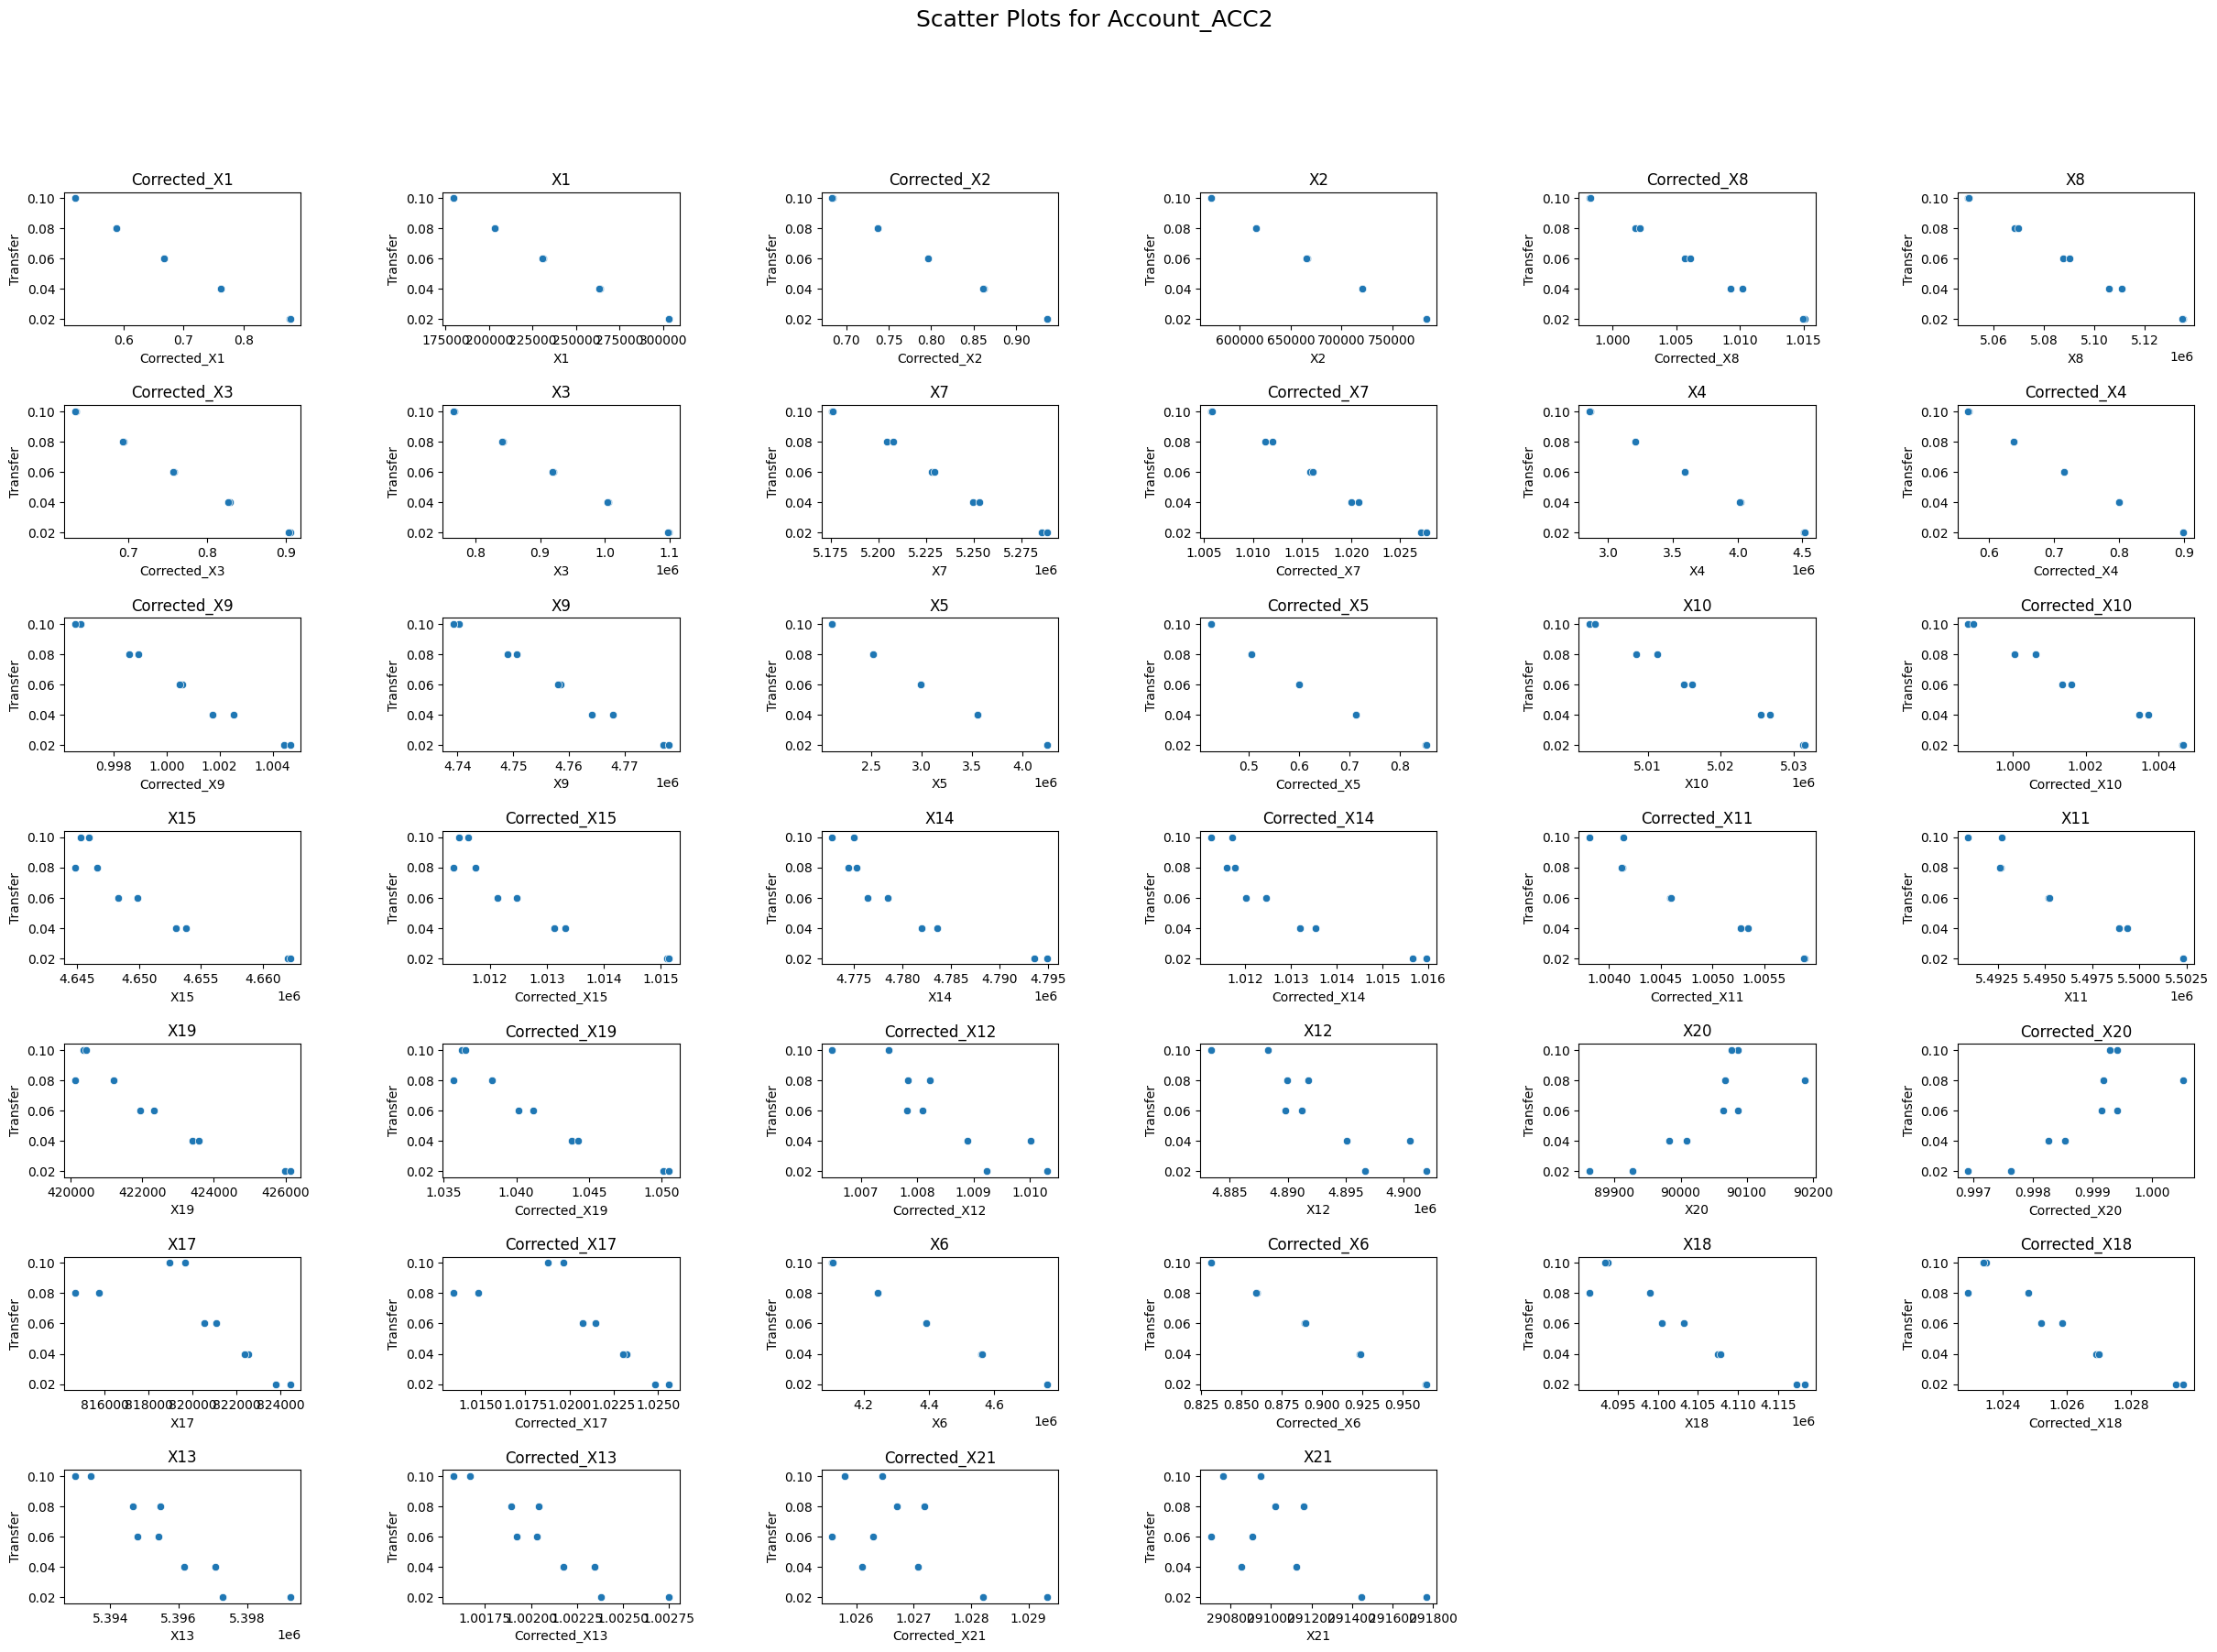

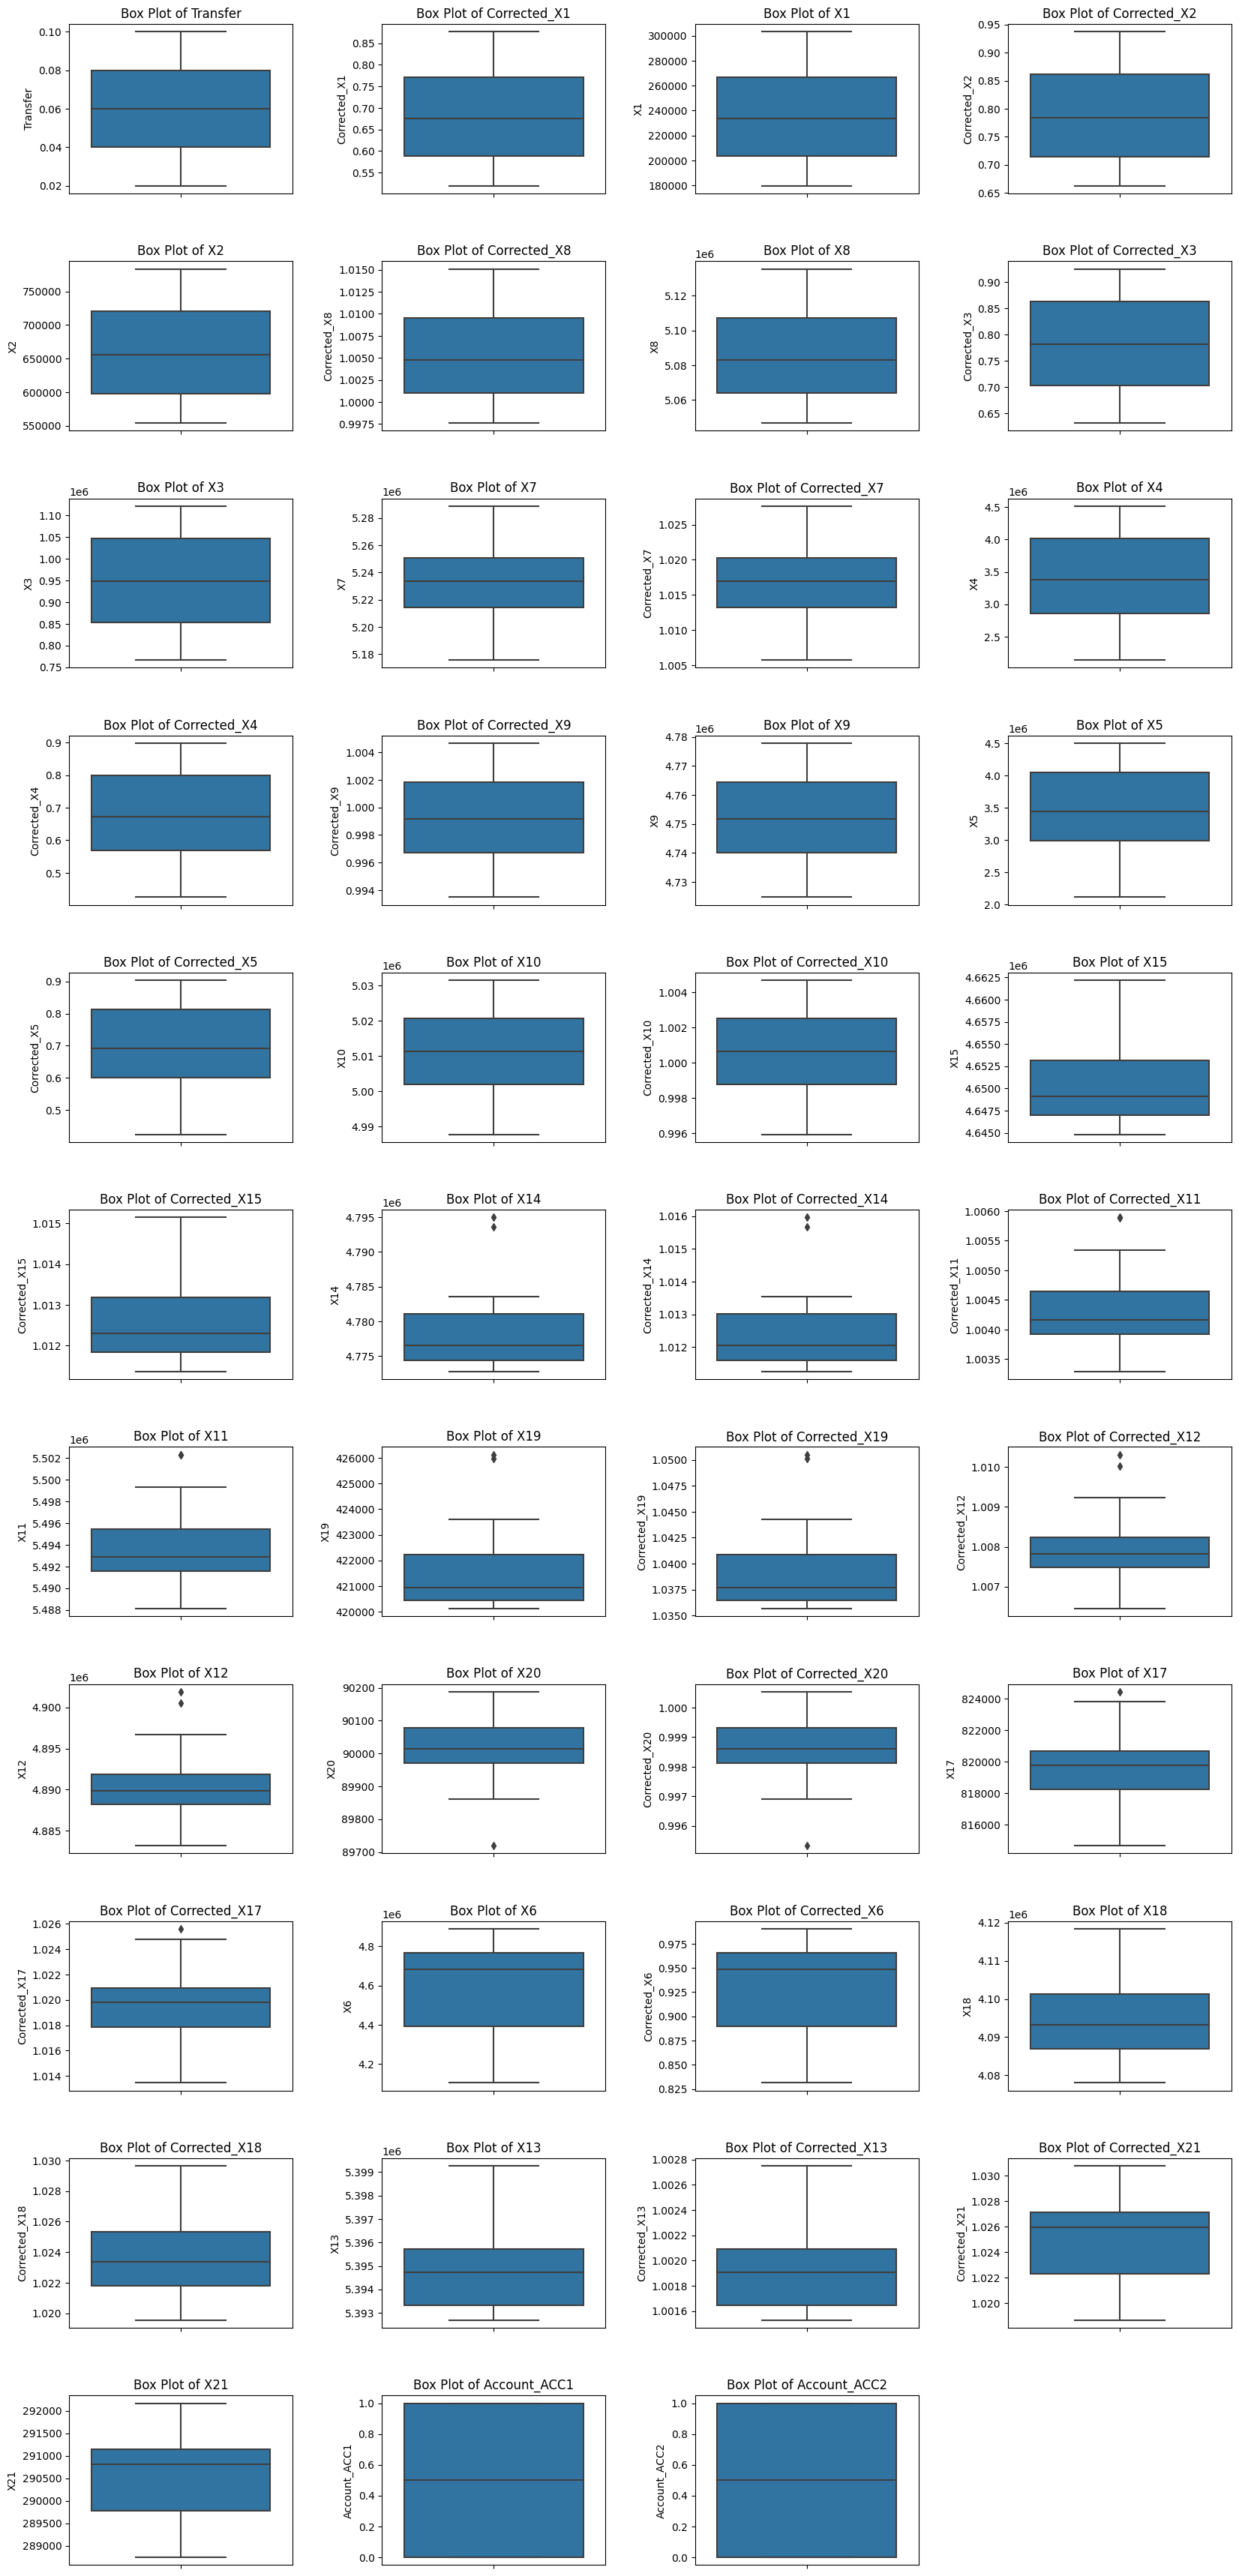

-----------------------------
Training set size: 14
-----------------------------
Test set size: 6
---------------------------------------Pridiction Results---------------------------------------


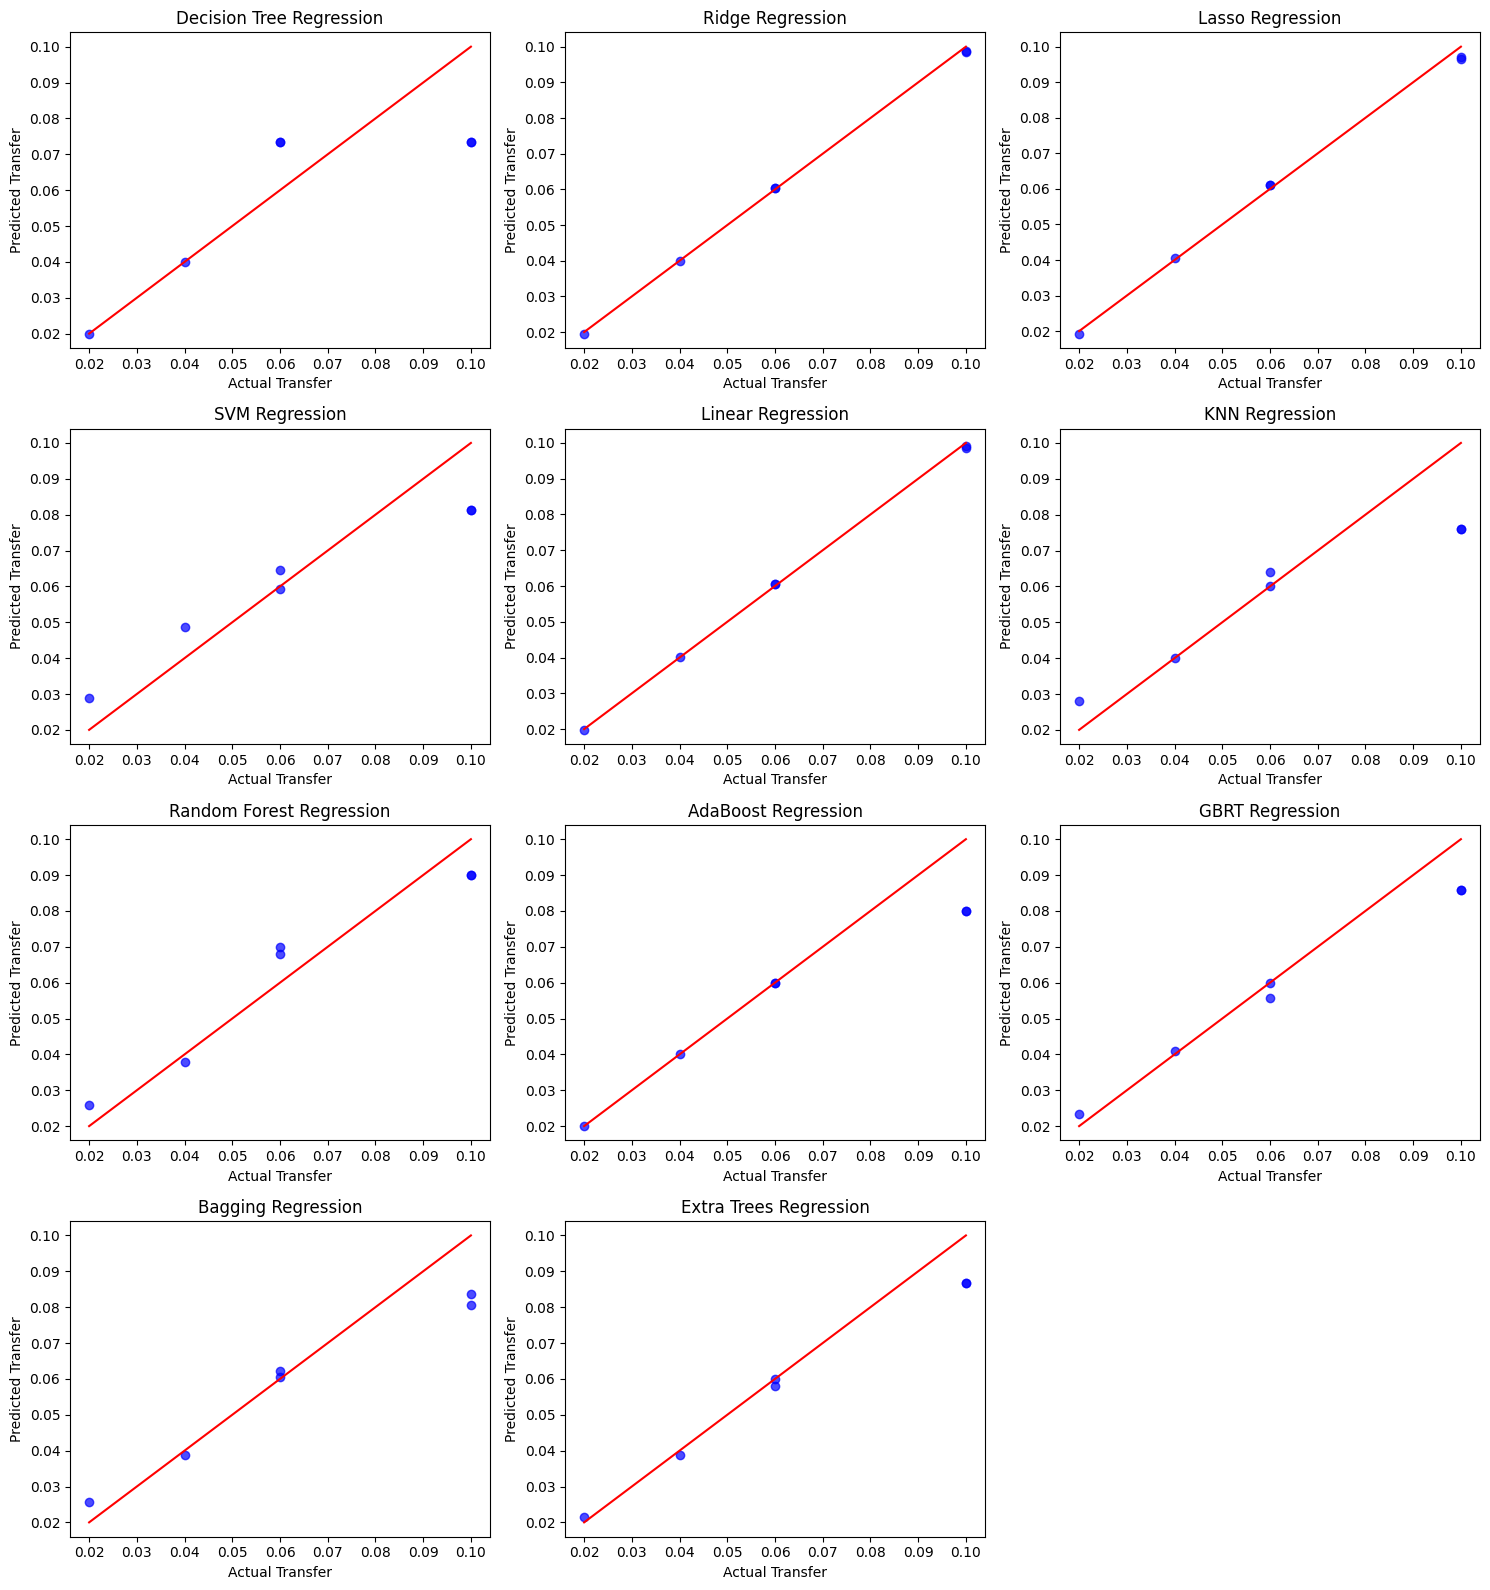

---------------------------------------Model Scores---------------------------------------


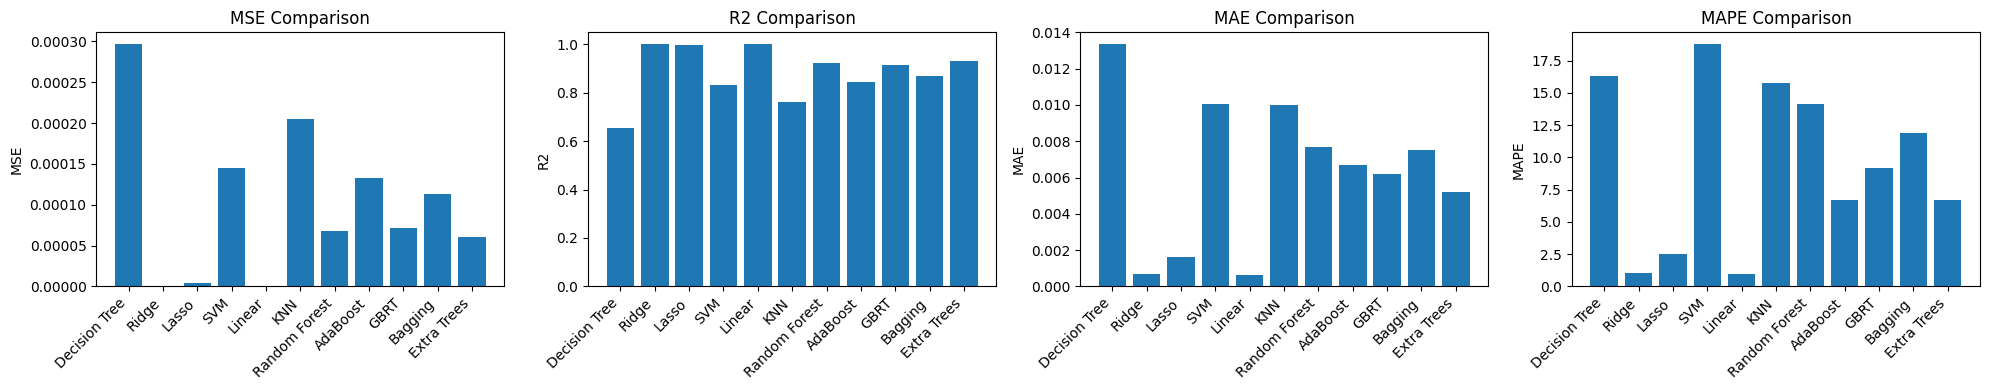

---------------------------------------
The best Model IS : LinearRegression()
---------------------------------------
Model Rankings by Average Rank:
Linear            1.00
Ridge             2.00
Lasso             3.00
Extra Trees       4.25
GBRT              5.75
Random Forest     6.50
AdaBoost          6.50
Bagging           7.00
KNN               9.50
SVM               9.75
Decision Tree    10.75
Name: Average Rank, dtype: float64
---------------------------------------
Notebook exported as HTML to output.html


In [156]:
main(file_path)